## Домашняя работа
Найти данные о заболеваемости/смертности/выздоровлении COVID-19 (они есть например на Kaggle) и использовать их для решения заданий. Можно использовать как данные по какому-то конкретному региону/стране, так и данные по всему миру.

Скорее всего, результат по всем задачам получится не очень.

## Normal
Применить градиентный бустинг для решения задачи. Используя кросс-валидацию, сравнить результаты ARIMA и бустинга.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools

In [27]:
df = pd.read_csv(r'D:\Курсы Питон\covid_jpn_prefecture.csv', index_col=0, parse_dates=True)
df

,Prefecture,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
Date,,,,,,,
2020-03-18,Hokkaido,154,1587.0,69.0,7.0,NaN,NaN
2020-03-18,Aomori,0,75.0,0.0,0.0,NaN,NaN
2020-03-18,Iwate,0,24.0,0.0,0.0,NaN,NaN
2020-03-18,Miyagi,1,138.0,1.0,0.0,NaN,NaN
2020-03-18,Akita,2,109.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
2022-07-22,Kumamoto,154729,348863.0,134586.0,336.0,19807.0,5.0
2022-07-22,Oita,76588,678048.0,66256.0,176.0,10156.0,0.0
2022-07-22,Miyazaki,73991,201123.0,64450.0,153.0,9275.0,1.0


In [28]:
df_vr = df.groupby("Date").sum()

In [29]:
# обработка трех дат, когда корректировали статистику по заболевшим
df_vr.loc["2020-03-26", 'Positive' ] = 1354
df_vr.loc["2020-11-09", 'Positive' ] = 107657
df_vr.loc["2022-03-16", 'Positive' ] = 5926625

In [30]:
df_vr['n_confirmed'] = df_vr['Positive'].diff()
df_vr['n_fatal'] = df_vr['Fatal'].diff()

In [31]:
df_vr = df_vr.drop(['Positive', 'Fatal', 'Tested', 'Discharged', 'Hosp_severe'], axis=1)

In [32]:
dff_vr = df_vr.dropna(subset=['n_confirmed'])

<AxesSubplot:xlabel='Date'>

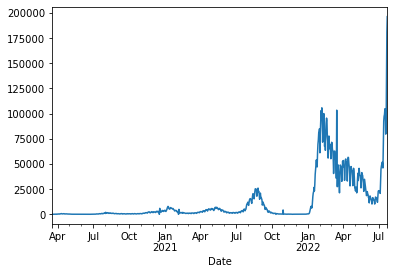

In [33]:
dff_vr['n_confirmed'].plot()

In [34]:
dff_vr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 856 entries, 2020-03-19 to 2022-07-22
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hosp_require  856 non-null    float64
 1   n_confirmed   856 non-null    float64
 2   n_fatal       856 non-null    float64
dtypes: float64(3)
memory usage: 26.8 KB


In [35]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [37]:
k = 5
X = []
Y = []
for i in range(len(dff_vr['n_confirmed']) - k):
    X.append(dff_vr['n_confirmed'].iloc[i:i+k])
    Y.append(dff_vr['n_confirmed'].iloc[i+k])
X = np.array(X)
Y = np.array(Y)

In [ ]:
params = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'n_estimators' : [100, 500, 1000, 1500],
    'max_depth'    : [4, 6, 8, 10]
}
search = RandomizedSearchCV(GradientBoostingRegressor(), params, scoring='r2')
search.fit(X, Y)
search.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000)

In [38]:
train_end = 700
pred = []
for i in range(train_end, len(X)):
    RGB = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000)
    RGB.fit(X[:i], Y[:i])
    pred_ = RGB.predict([X[i]])
    pred.append(pred_)
pred = np.array(pred).ravel()

In [40]:
from sklearn.metrics import r2_score
r2_score(Y[train_end:], pred)

0.7173188202984642

In [41]:
r2_score(Y[train_end + 1:], Y[train_end:-1])

0.7974841398891754

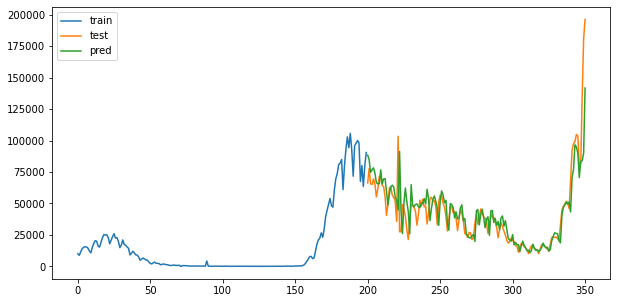

In [42]:
train_series = dff_vr['n_confirmed'].iloc[train_end-200:train_end]
test_series = pd.Series(Y[train_end:])
pred_series = pd.Series(pred)
plt.figure(figsize=(10, 5))
plot_train_test_pred(train_series, test_series, pred_series)

In [43]:
import pmdarima as pm
# Fit a simple auto_arima model
arima = pm.auto_arima(dff_vr['n_confirmed'].iloc[1:train_end],
                      seasonal=True,
                      trace=True,
                      )
pmd_predictions = arima.predict(n_periods=len(pd.Series(Y[train_end:])))

arima_mae = np.mean(np.abs(pd.Series(Y[train_end:]) - pmd_predictions))
arima_rmse = (np.mean((pd.Series(Y[train_end:]) - pmd_predictions)**2))**.5
arima_mape = np.sum(np.abs(pmd_predictions - pd.Series(Y[train_end:]))) / (np.sum((np.abs(pd.Series(Y[train_end:])))))

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=13041.482, Time=0.60 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=13648.404, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=13361.587, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=12950.887, Time=0.47 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=13038.503, Time=0.29 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=12945.566, Time=0.53 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=12951.224, Time=0.14 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=12946.531, Time=0.23 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=12946.878, Time=0.14 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=12749.873, Time=0.84 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=12868.818, Time=0.54 sec
 ARIMA(2,2,5)(0,0,0)[0]             :

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
model_fit = ARIMA(dff_vr['n_confirmed'].iloc[1:train_end], order=(2, 2, 4)).fit()
print('AIC=', model_fit.aic)

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC= 12749.873064666348


D:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

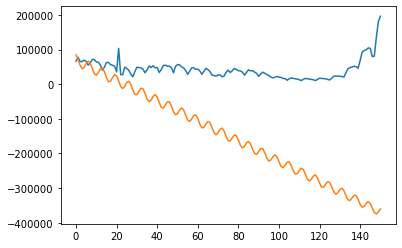

In [46]:
pd.Series(Y[train_end:]).plot()
pd.Series(pmd_predictions).plot()

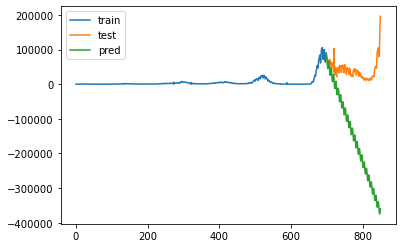

In [47]:
plot_train_test_pred(dff_vr['n_confirmed'].iloc[1:train_end], pd.Series(Y[train_end:]), pd.Series(pmd_predictions))

## Hard

Применить библиотеку Prophet, сравнить результаты с предыдущими двумя.

Сравнить результат с бейзлайн-решением (прогноз на завтра - сегодняшнее количество).

Сравнить результат со сглаживанием и без.

Оценить остатки всех трех моделей, проверить гипотезу, что остатки распределены нормально.

In [48]:
cdt = pd.read_csv(r'D:\Курсы Питон\covid_jpn_prefecture.csv', index_col=0, parse_dates=True)
cdt

,Prefecture,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
Date,,,,,,,
2020-03-18,Hokkaido,154,1587.0,69.0,7.0,NaN,NaN
2020-03-18,Aomori,0,75.0,0.0,0.0,NaN,NaN
2020-03-18,Iwate,0,24.0,0.0,0.0,NaN,NaN
2020-03-18,Miyagi,1,138.0,1.0,0.0,NaN,NaN
2020-03-18,Akita,2,109.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
2022-07-22,Kumamoto,154729,348863.0,134586.0,336.0,19807.0,5.0
2022-07-22,Oita,76588,678048.0,66256.0,176.0,10156.0,0.0
2022-07-22,Miyazaki,73991,201123.0,64450.0,153.0,9275.0,1.0


In [49]:
from prophet import Prophet

In [50]:
cdt_vr = cdt.groupby("Date").sum()

In [51]:
# обработка трех дат, когда корректировали статистику по заболевшим
cdt_vr.loc["2020-03-26", 'Positive' ] = 1354
cdt_vr.loc["2020-11-09", 'Positive' ] = 107657
cdt_vr.loc["2022-03-16", 'Positive' ] = 5926625

In [52]:
cdt_vr['y'] = cdt_vr['Positive'].diff()

In [53]:
cdt_vr = cdt_vr.drop(['Positive', 'Fatal', 'Tested', 'Discharged', 'Hosp_severe', 'Hosp_require'], axis=1)

In [54]:
cdt_v = cdt_vr.dropna(subset=['y'])

In [55]:
cdt_v['ds'] = cdt_v.index.tolist()
cdt_v

C:\Users\Анна\AppData\Local\Temp\ipykernel_7212\1213298016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdt_v['ds'] = cdt_v.index.tolist()


,y,ds
Date,,
2020-03-19,36.0,2020-03-19
2020-03-20,49.0,2020-03-20
2020-03-21,37.0,2020-03-21
2020-03-22,42.0,2020-03-22
2020-03-23,36.0,2020-03-23
...,...,...
2022-07-18,79598.0,2022-07-18
2022-07-19,81342.0,2022-07-19
2022-07-20,135198.0,2022-07-20


In [56]:
m = Prophet()
m.fit(cdt_v)

16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:51 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1216,2023-07-18
1217,2023-07-19
1218,2023-07-20
1219,2023-07-21
1220,2023-07-22


In [58]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1216,2023-07-18,118500.178380,93763.619229,141518.469415
1217,2023-07-19,121025.228273,95880.294832,143662.263694
1218,2023-07-20,121911.002727,97138.995327,146440.567285
1219,2023-07-21,122257.241691,96495.841336,145533.928028
1220,2023-07-22,120820.082077,95297.508535,144310.270789


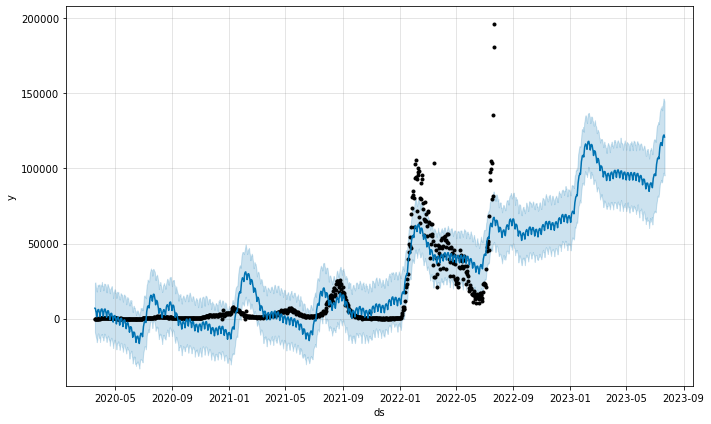

In [59]:
fig1 = m.plot(forecast)

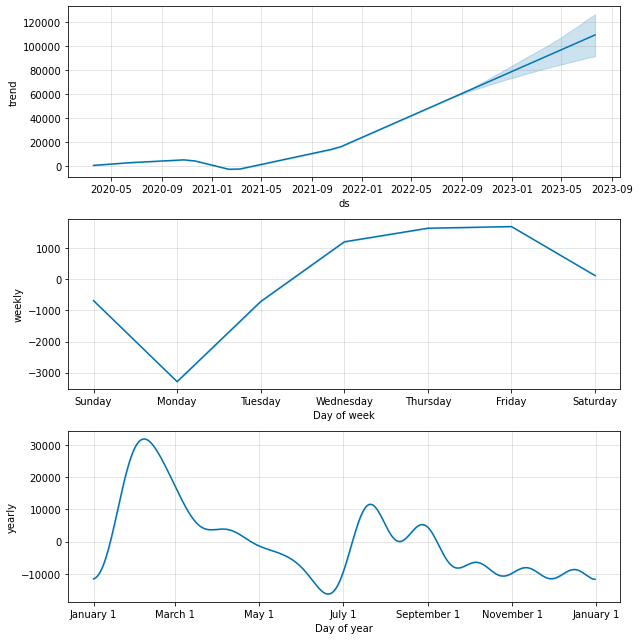

In [60]:
fig2 = m.plot_components(forecast)

In [61]:
X_train = cdt_v[:700]

In [63]:
X_test = cdt_v[700:]

16:39:23 - cmdstanpy - INFO - Chain [1] start processing
16:39:23 - cmdstanpy - INFO - Chain [1] done processing


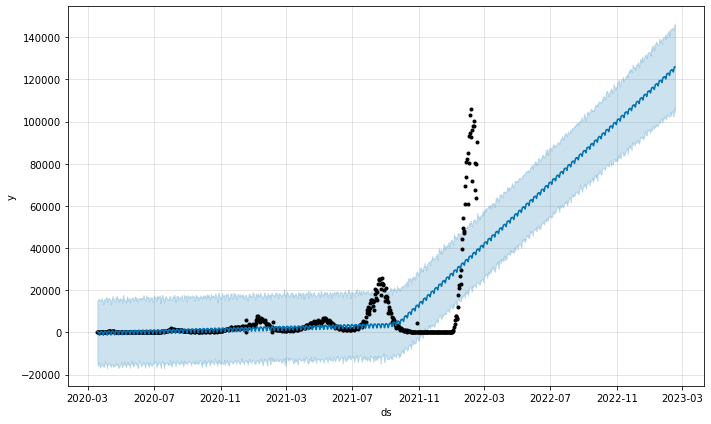

In [65]:
mtr = Prophet()
mtr.fit(X_train)
future_tr = mtr.make_future_dataframe(periods=365)
forecast_tr = mtr.predict(future_tr)
fig3 = mtr.plot(forecast_tr)

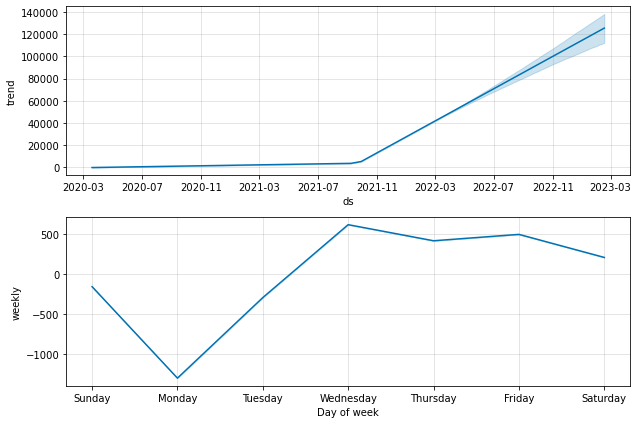

In [66]:
fig4 = mtr.plot_components(forecast_tr)

In [87]:
train_end = 700
pred = []
for i in range(train_end, len(cdt_v)):
    mtr = Prophet()
    mtr.fit(cdt_v[:i])
    future = mtr.make_future_dataframe(periods=1)
    forecast = mtr.predict(future)
    pred_ = forecast[['yhat']].iloc[-1]
    pred.append(pred_)
pred = np.array(pred).ravel()

17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:23 - cmdstanpy - INFO - Chain [1] start processing
17:37:23 - cmdstanpy - INFO - Chain [1]

In [93]:
r2_score(cdt_v.y[700:], pred)

0.0649499727405638

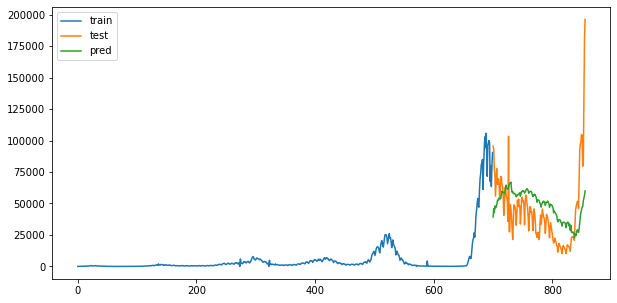

In [92]:
train_series = cdt_v.y[:700]
test_series = cdt_v.y[700:]
pred_series = pd.Series(pred)
plt.figure(figsize=(10, 5))
plot_train_test_pred(train_series, test_series, pred_series)